
## Introduction Slides
- introduce data, aim of area segmentation
- gray/white matter segmentation very important, and good use-case for tutorial, because can be done with slightly lower resolution and needs less training data
- as bonus, show segmentation of V1 from 20um BigBrain sections (using pre-trained segmentation network?)

# Segmentation of high-resolution histological brain sections
# 0. Set up Notebook & download data

In [1]:
import keras
import numpy as np
from keras.layers.convolutional import Convolution2D
from keras.layers import Input, UpSampling2D, MaxPooling2D, Concatenate, Cropping2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import imageio
import os
import re
import glob
from tqdm import tqdm
from receptive_field import calculate_receptive_field, suggest_input_sizes

%matplotlib inline

def get_section_no(name):
    if isinstance(name, list):
        res = []
        for n in name:
            res.append(get_section_no(n))
        return res
    else:
        return re.findall(r'\d\d\d\d', name)[-1]

Using TensorFlow backend.


In [2]:
data_dir = 'data'
# download train, val, and test data (prepared with create-datasets.ipynb notebook)
data_url = 'https://fz-juelich.sciebo.de/s/tFG1H8bAJfyok3E/download'
data_archive = os.path.join(data_dir, 'data.zip')
!mkdir -p {data_dir}
!wget -nc {data_url} -O {data_archive}
!unzip -uo {data_archive} -d . 


File ‘data/data.zip’ already there; not retrieving.
Archive:  data/data.zip


In [3]:
# look at structure of data directory
!ls -R {data_dir} --ignore raw

sections_fname = os.path.join(data_dir, 'test/B20_{}.png')
masks_v1_fname = os.path.join(data_dir, 'test/B20_{}_v1.png')
masks_gmwm_fname = os.path.join(data_dir, 'test/B20_{}_gmwm.png')

# split available sections in train/val and test sections
imgs = sorted(glob.glob(masks_v1_fname.format('*')))
test_sections = get_section_no(imgs)

print('Test sections', test_sections)

data:
data.zip  test.tar	  train_v1.npz	val_v1.npz
test	  train_gmwm.npz  val_gmwm.npz

data/test:
B20_0361_gmwm.png  B20_0721_v1.png    B20_1441.png	 B20_2161_gmwm.png
B20_0361.png	   B20_1081_gmwm.png  B20_1441_v1.png	 B20_2161.png
B20_0361_v1.png    B20_1081.png       B20_1801_gmwm.png  B20_2161_v1.png
B20_0721_gmwm.png  B20_1081_v1.png    B20_1801.png
B20_0721.png	   B20_1441_gmwm.png  B20_1801_v1.png
Test sections ['0361', '0721', '1081', '1441', '1801', '2161']


## Data
All necessary data for execution of this notebook is available from `X`. This contains test sections, and precomputed train and val datasets of image patches from the large histological sections.

- **Input** (``data/test/B20_0000.png``): histological sections at 20um resolution from the BigBrain (Amunts, 2013)
    - available from ``ftp://bigbrain.loris.ca/BigBrainRelease.2015/2D_Final_Sections/Coronal/Png/Full_Resolution``
    - images contain gray values between 0 and 255 (8 bit)
    
    
- **Desired Output (1)** (``data/test/masks_gmwm``): segmentation of the input in 3 classs: gray matter, white matter, and background
    - groundtruth labels based on labeled volume of the BigBrain available from ``ftp://bigbrain.loris.ca/BigBrainRelease.2015/3D_Classified_Volumes/Histological_Space/full_cls_100um.nii.gz``
    - slicing of the volume provided by Christian Schiffer (c.schiffer@fz-juelich.de)
    - label images encode background with 0, gray matter with 128, white matter with 255
    - Note that the gm/wm segmentation is far from perfect (derived from automatically calculated segmentation). For real applications, groundtruth data needs to be better. Otherwise the neural network will learn to mimic systematic errors in the labels!
    
- **Desired Output (2)** (``data/masks_v1``): segmentation of the input in 2 classes: V1, background
    - groundtruth labels available in HBP Knowledge Graph from ``https://www.humanbrainproject.eu/en/explore-the-brain/search/?facet_type[0]=Dataset#Dataset/87c6dea7-bdf7-4049-9975-6a9925df393f`` (DOI: 10.25493/3GSV-T4A)
    - label images encode background with 0, V1 with 255
    


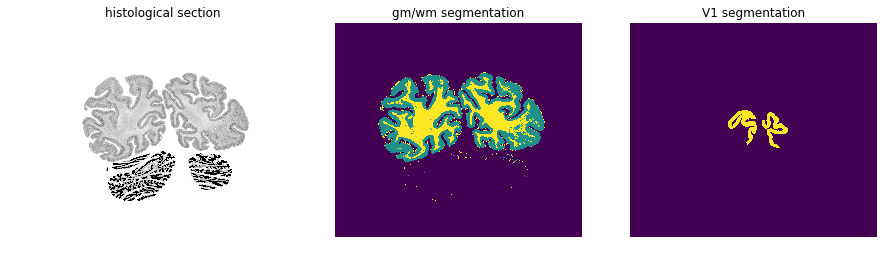

In [4]:
#load and display section and label
img = imageio.imread(sections_fname.format('1081'))
mask_v1 = imageio.imread(masks_v1_fname.format('1081'))
mask_gmwm = imageio.imread(masks_gmwm_fname.format('1081'))

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("histological section")
axes[1].imshow(mask_gmwm)
axes[1].set_title("gm/wm segmentation")
axes[2].imshow(mask_v1)
axes[2].set_title("V1 segmentation")
for ax in axes:
    ax.axis("off")

# 1. Gray/white matter segmentation
## 1.1. Prepare data for training
**Challenge**: Histological sections are too large to process at once during training:
- GPU memory too small,
- Effective number of training samples too low

**Solution**: Crop small patches from input images and use for training

*Choices for patch sampling*:
- How large should the input be?
    - Trade-off between efficiency (shared computations for convolutions for large inputs) and variability of data (many small inputs show more different data than one large input)
    - Input patches need to show relevant context
    - Minimal input size may be limited by choice of network architecture (receptivel field - more on that later!)
    - Here, patch size of 256x256px is chosen. 256x256px at 20um per pixel shows 5x5mm of tissue. Sufficient for gray/white matter segmentation
- How many patches should be sampled?
    - As many as possible! Here, patches are computed beforehand (reproducible and faster), but random sampling during training is also possible and increases the variability of the training data
- Where should the patches be sampled from?
    - From the interesting parts of the image!
    - E.g., higher sampling rate from cortex and white matter than background might be beneficial
    - Here, patches were sampled such that each class is represented evenly in the dataset (possible improvement: sample less patches from background class, because it is very easy to learn)
    
For this course, train and val datasets of randomly cropped patches were prepared in advance. If interested, have a look at `create-datasets.ipynb`

In [5]:
# load precomputed train patches
res = np.load(os.path.join(data_dir, "train_gmwm.npz"))
X_train = res['X']
Y_train = res['Y']
res.close()

# load precomputed val patches
res = np.load(os.path.join(data_dir, "val_gmwm.npz"))
X_val = res['X']
Y_val = res['Y']
res.close()

Train dataset shape (n_samples, height, width, n_channels): (500, 268, 268, 1)
Val dataset shape (n_samples, height, width, n_channels): (20, 268, 268, 1)


Text(0.5, 0.98, 'Example val patches')

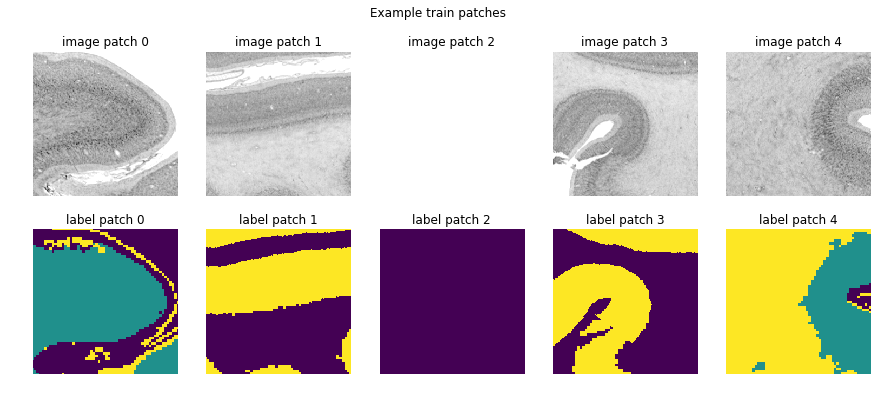

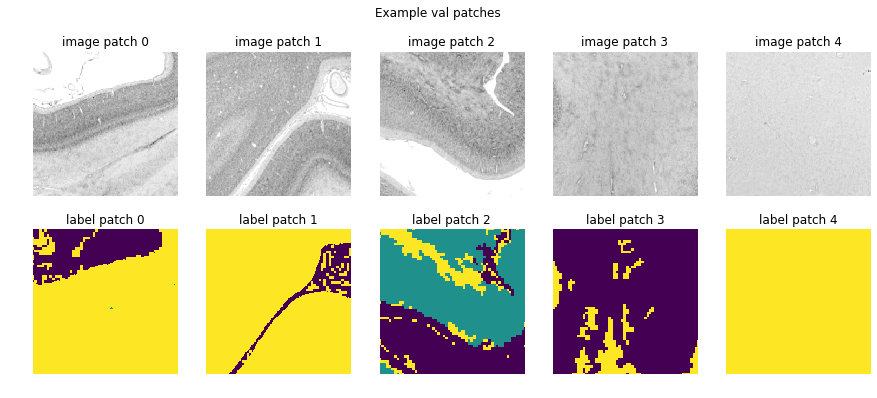

In [145]:
def plot_dataset(X, Y, num=5, vmin=0, vmax=255, vmax_labels=2):
    fig, axes = plt.subplots(2,num, figsize=(15,6))
    for i,ax in enumerate(axes[0]):
        ax.imshow(X[i,:,:,0], cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
        ax.set_title('image patch {}'.format(i))
    for i,ax in enumerate(axes[1]):
        ax.imshow(Y[i,:,:,0], vmin=0, vmax=vmax_labels)
        ax.axis('off')
        ax.set_title('label patch {}'.format(i))
    return fig

print("Train dataset shape (n_samples, height, width, n_channels): {}".format(X_train.shape))
print("Val dataset shape (n_samples, height, width, n_channels): {}".format(X_val.shape))

# visualize image and label patches
fig = plot_dataset(X_train, Y_train)
fig.suptitle("Example train patches")

fig = plot_dataset(X_val, Y_val)
fig.suptitle("Example val patches")


## 1.2. U-Net architecture for image segmentation
- Neural network for segmentation of large images should be memory-efficient, to enable training with large batch sizes
- U-Net is good choice for segmentation (Ronneberger, 2015)
    - Fully-convolutional, allows tiled prediction of very large images
    - Downsampling branch consisting of blocks of two convolutions and a pooling layer
    - Upsampling branch consisting of an upsampling layer and two convolutions

<img src="files/u-net-architecture.png" style="width:600px">

*Choices for design of custom U-Net*:
- How many blocks? How many convolutions per block? What filter size? Etc...
    - Original U-net architecture is a good starting point, but might not be optimal
    - *Receptive field* is important. This determines how many pixels the network "sees" for the prediction of one pixel. The receptive field is increased by pooling layers and convolutional layers
   
**Important**: If tiled segmentation of a large image is desired, only *valid* convolutions should be used 
- Otherwise, predictions at the borders of the image patches are not correct
- This results in a smaller output size than input size
- Groundtruth labels need to be cropped to the smaller output size when calculating performance metrics


In [7]:
def crop_to_shape_tensor(input_tensor, template_tensor):
    """Crop input_tensor to the shape of template_tensor by applying a cropping2D layer.
    Throw ValueError if template_tensor has a larger size than input_tensor
    
    Args:
        input_tensor: Tensor with shape attribute
        template_tensor: Tensor with shape attribute
    """
    from_shape = np.array(input_tensor.shape.as_list()[1:3])
    to_shape = np.array(template_tensor.shape.as_list()[1:3])
    if np.any(to_shape > from_shape):
        raise ValueError("template_tensor is larger than input_tensor with shapes {} and {}".format(to_shape, from_shape))
    # crop from left/top
    crop1 = np.floor((from_shape-to_shape)/2.).astype(int)
    # crop from right/bottom
    crop2 = np.ceil((from_shape-to_shape)/2.).astype(int)
    cropped_tensor = Cropping2D(cropping=((crop1[0], crop2[0]), (crop1[1], crop2[1])))(input_tensor)
    return cropped_tensor

def crop_to_shape(arr, shape):
    """Crop arr to the shape of template_arr.
    Throw ValueError if shape is larger than arr.shape
    
    Args:
        arr: np.array with shape (., h, w, .)
        shape: desired shape (h,w)
    """
    from_shape = np.array(arr.shape[1:3])
    to_shape = np.array(shape)
    if np.any(to_shape > from_shape):
        raise ValueError('shape is larger than arr.shape with {} {}'.format(to_shape, from_shape))
    crop = np.floor((from_shape-to_shape)/2.).astype(np.uint8)
    return arr[:,crop[0]:shape[0]+crop[0],crop[1]:shape[1]+crop[1]]
    

In [125]:
# U-Net definition
def u_net(input_tensor, num_classes=3):  
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='down1_c1')(input_tensor)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='down1_c2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='down1_p1')(conv1)
 
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down2_c1')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down2_c2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='down2_p1')(conv2)

    conv3 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down3_c1')(pool2)
    conv3 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down3_c2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='down3_p1')(conv3)
    
    conv4 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='down4_c1')(pool3)
    conv4 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='down4_c2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='down4_p1')(conv4)

    conv5 = Convolution2D(256, (3, 3), activation='relu', padding='valid', name='bottom_c1')(pool4)
    conv5 = Convolution2D(256, (3, 3), activation='relu', padding='valid', name='bottom_c2')(conv5)

    up6 = UpSampling2D(size=(2, 2), name='up4_up')(conv5)
    # due to border pixel loss, conv3 is larger than up5 - crop conv3 to shape of up5 to concatenate
    crop4 = crop_to_shape_tensor(conv4, up6)
    conc6 = Concatenate(axis=3)([up6, crop4])
    conv6 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='up4_c1')(conc6)
    conv6 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='up4_c2')(conv6)

    up7 = UpSampling2D(size=(2, 2), name='up3_up')(conv6)
    crop3 = crop_to_shape_tensor(conv3, up7)
    conc7 = Concatenate(axis=3)([up7, crop3])
    conv7 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='up3_c1')(conc7)
    conv7 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='up3_c2')(conv7)
    
    up8 = UpSampling2D(size=(2, 2), name='up2_up')(conv7)
    crop2 = crop_to_shape_tensor(conv2, up8)
    conc8 = Concatenate(axis=3)([up8, crop2])
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up2_c1')(conc8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up2_c2')(conv8)
    
    up9 = UpSampling2D(size=(2, 2), name='up1_up')(conv8)
    crop1 = crop_to_shape_tensor(conv1, up9)
    conc9 = Concatenate(axis=3)([up9, crop1])
    conv9 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up1_c1')(conc9)
    conv9 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up1_c2')(conv9)

    output_tensor = Convolution2D(num_classes, (1, 1), activation='softmax', name='output')(conv9)

    return keras.models.Model(input=[input_tensor], output=output_tensor)
    
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 268, 268, 1)  0                                            
__________________________________________________________________________________________________
down1_c1 (Conv2D)               (None, 266, 266, 32) 320         input_12[0][0]                   
__________________________________________________________________________________________________
down1_c2 (Conv2D)               (None, 264, 264, 32) 9248        down1_c1[0][0]                   
__________________________________________________________________________________________________
down1_p1 (MaxPooling2D)         (None, 132, 132, 32) 0           down1_c2[0][0]                   
__________________________________________________________________________________________________
down2_c1 (

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


### Receptive field 
Width of the window of pixels on the input image that are considered by the model to make a decision for an output pixel

In [126]:
model.input_layers = [model.layers[0]]
model.output_layers = [model.layers[-1]]

rf = calculate_receptive_field(model)
print("Receptive field of model is",rf)

Receptive field of model is 184.0


Not every input size is a valid input size. Since the aim is to train a model that can predict larger inputs, it is important that pixels at the boder of the input image are not discarded or treated differently. 
Thus, pooling layers should always get an even input size!

Below, we calculate valid input sizes for the model and confirm that our input size is valid

In [127]:
suggest_input_sizes(model, 268) # input size of 268 is valid

[(252.0, 68.0), (268.0, 84.0), (284.0, 100.0)]

## 1.3. Neural network training 
*Training hyperparameters*:
- Optimizer: SGD with learning rate 0.001, momentum 0.9 (other choices are e.g. Adam optimizer)
- Number of iterations: 2 epochs with batch size 32
- Metric: crossentropy during training and accuracy during evaluation (other choices for segmentation are e.g.  Dice/F1 score)
- Input data is centered to mean 0 and stddev 1
- **Data augmentation**: currently none, more on that later!

In [128]:
# crop groundtruth labels to fit to the smaller output size of the model (due to only 'valid' convolutions)
Y_train_cropped = crop_to_shape(Y_train, model.output.shape.as_list()[1:3])
Y_val_cropped = crop_to_shape(Y_val, model.output.shape.as_list()[1:3])
print("Shape before cropping: {}. Shape after cropping: {}.".format(Y_train.shape, Y_train_cropped.shape))

# create generator for batches that centers mean and std deviation of training data
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(X_train)

Shape before cropping: (500, 268, 268, 1). Shape after cropping: (500, 84, 84, 1).


In [129]:
# parameters for training
lr = 0.001
momentum = 0.9
epochs = 10
batch_size = 24
model_name = 'model_gmwm.hdf5'

# prepare model for training
sgd = SGD(lr=lr, momentum=momentum, nesterov=True)

# use accuracy function from current Keras master, function in keras-2 release does not work as expected for segmentation
def sparse_categorical_accuracy(y_true, y_pred):
    import keras.backend as K
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=[sparse_categorical_accuracy] )

# train model
history_gmwm = model.fit_generator(datagen.flow(X_train, Y_train_cropped, batch_size=batch_size),
                             steps_per_epoch=X_train.shape[0]//batch_size, 
                              epochs=epochs, verbose=2,
                             validation_data=datagen.flow(X_val, Y_val_cropped, batch_size=len(X_val)).next())

# save model   
model.save(model_name)


Epoch 1/10
 - 13s - loss: 1.0117 - sparse_categorical_accuracy: 0.5931 - val_loss: 0.9331 - val_sparse_categorical_accuracy: 0.6930
Epoch 2/10
 - 11s - loss: 0.8178 - sparse_categorical_accuracy: 0.5851 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.8036
Epoch 3/10
 - 11s - loss: 0.5747 - sparse_categorical_accuracy: 0.8403 - val_loss: 0.5315 - val_sparse_categorical_accuracy: 0.8027
Epoch 4/10
 - 11s - loss: 0.4292 - sparse_categorical_accuracy: 0.8489 - val_loss: 0.5151 - val_sparse_categorical_accuracy: 0.7742
Epoch 5/10
 - 11s - loss: 0.4080 - sparse_categorical_accuracy: 0.8468 - val_loss: 0.4789 - val_sparse_categorical_accuracy: 0.7818
Epoch 6/10
 - 11s - loss: 0.4077 - sparse_categorical_accuracy: 0.8414 - val_loss: 0.4601 - val_sparse_categorical_accuracy: 0.7765
Epoch 7/10
 - 11s - loss: 0.3924 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.4664 - val_sparse_categorical_accuracy: 0.7682
Epoch 8/10
 - 11s - loss: 0.3806 - sparse_categorical_accuracy: 0.8515 - val

Plot progress of train and val loss

In [130]:
print(history_gmwm.history.keys())

dict_keys(['val_loss', 'val_sparse_categorical_accuracy', 'loss', 'sparse_categorical_accuracy'])


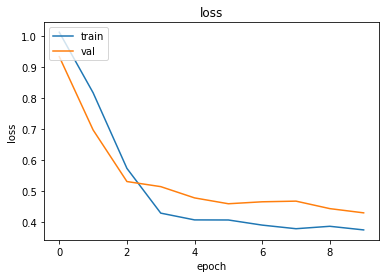

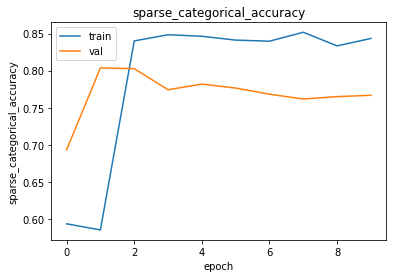

In [131]:
def plot_history(history, key='loss'):
    # summarize history for accuracy
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title(key)
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history_gmwm, key='loss')
plot_history(history_gmwm, key='sparse_categorical_accuracy')

## 1.4. Evaluate model
Evaluatiom on whole slide histological images
- if fits in memory, can predict at once, otherwise need to do patch-wise prediction (with slightly overlapping patches due to pixel loss during valid convolutions)
- need to create model with correct input size input sizes to evaluate large images and load saved weights

In [95]:
# recreate unet model with larger input size
input_shape = (1020,1020,1)
model_name = 'model_gmwm.hdf5'
# ensure that this is a valid input size
print('Possible input/output sizes of model are:', suggest_input_sizes(model, input_shape[0])) 

input_tensor = Input(shape=input_shape)
eval_model = u_net(input_tensor)
eval_model.load_weights(model_name)

print("For input shape {} the output shape is {}".format(eval_model.input_shape, eval_model.output_shape)) 

Possible input/output sizes of model are: [(1004.0, 820.0), (1020.0, 836.0), (1036.0, 852.0)]


/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


For input shape (None, 1020, 1020, 1) the output shape is (None, 836, 836, 3)


In [96]:
# functions for creating overlapping patches and writing results back in large image
def create_grid(img, spacing):
    """Calculate evenly spaced grid over image
    Args:
        img: array with shape (h,w)
        spacing: int
    Returns:
        list of tuples denoting the coordinate of each grid point
    """
    xx, yy = np.meshgrid(range(spacing//2, img.shape[0], spacing), range(spacing//2, img.shape[1], spacing))
    return np.array((xx.ravel(), yy.ravel())).T

def sample_from_coords(img, coords, patch_shape, pad=0):
    """Sample patches from coords
    Args:
        img: array with shape (h,w)
        coords: list of tuples denoting the center coordinate of each patch
        patch_shape: size of patches that should be sampled
        pad: int, padding value that is added if patches exceed image size
    """
    # pad image with padding value to make cropping easier
    pad_value = max(patch_shape)
    img_padded = np.zeros(np.array(img.shape)+np.array([pad_value*2, pad_value*2]))
    img_padded[pad_value:pad_value+img.shape[0],pad_value:pad_value+img.shape[1]] = img

    crops = []
    offset = np.array(patch_shape)//2
    for coord in coords:
        coord = np.array(coord)
        # coord is center point of crop, coord-offset is upper right corner of crop in img,
        # coord-offset+pad_value is upper left corner in img_padded
        ul = coord - offset + pad_value
        crop = img_padded[ul[0]:ul[0]+patch_shape[0],ul[1]:ul[1]+patch_shape[1]]
        crops.append(crop)
    return crops

def create_image_from_patches(patches, coords, shape):
    """Put predicted patches back in large image
    Args:
        patches (np.ndarray): shape (num_patches, h, w, num_classes)
        coords (list): each coordinate is a 2-tuple denoting the center coordinate of each patch in the original image
        shape (tuple): shape of the original image
    Returns:
        (np.ndarray): prediction image with shape `shape`
    """
    res = np.zeros(shape, dtype=np.uint8)
    offset = np.array(patches.shape[1:3])//2
    for i, coord in enumerate(coords):
        # coord is center of patch
        # coord - offset is upper left corner
        ul = coord - offset
        # ul + patches.shape[1:3] is lower right corner
        # adjust, if is outside of image shape
        lr = np.min([ul + np.array(patches.shape[1:3]), np.array(shape)], axis=0)
        res[ul[0]:lr[0],ul[1]:lr[1]] = np.argmax(patches[i,0:lr[0]-ul[0],0:lr[1]-ul[1]], axis=2)
    return res

Text(0.5, 0.98, 'extracted patches')

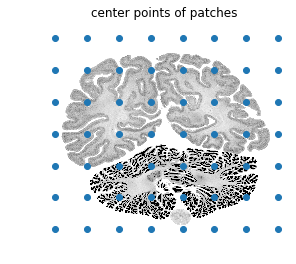

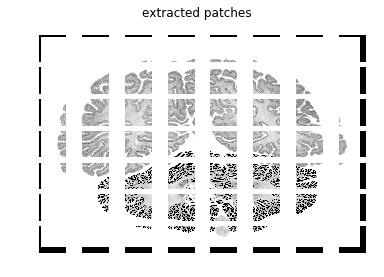

In [97]:
# predict large image by predicting grid of small overlapping images

# load image to predict
X_test = imageio.imread(sections_fname.format(test_sections[4]))
Y_test = imageio.imread(masks_gmwm_fname.format(test_sections[4]))

# create slightly overlapping patches from whole slide section
grid = create_grid(X_test, spacing=eval_model.output_shape[1])
patches = sample_from_coords(X_test, grid, patch_shape=eval_model.input_shape[1:3])

# plot grid on image
fig = plt.figure()
plt.imshow(X_test, cmap='gray')
plt.plot(grid[:,1], grid[:,0], 'o')
plt.axis('off')
plt.title('center points of patches')

# plot patches
fig, axes = plt.subplots(7,8)
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')
    ax.imshow(patches[i], cmap='gray')
plt.suptitle('extracted patches')

In [98]:
patches_to_predict = np.expand_dims(patches,3)
print(patches_to_predict.shape)
predicted_patches = eval_model.predict_generator(datagen.flow(patches_to_predict, batch_size=1, shuffle=False), steps=len(patches_to_predict))

(56, 1020, 1020, 1)


In [99]:
# create predicted image from patches
Z_test = create_image_from_patches(predicted_patches, grid, X_test.shape)

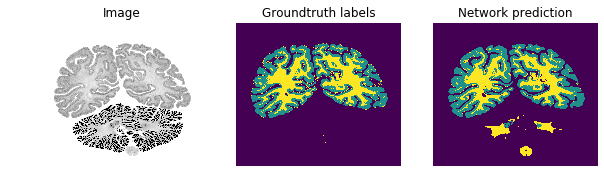

In [100]:
# show results
fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].imshow(X_test, cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(Y_test)
axes[1].set_title("Groundtruth labels")
axes[2].imshow(Z_test)
axes[2].set_title("Network prediction")
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')
   

# 2. V1 segmentation
# 2.1. Load data

Text(0.5, 0.98, 'Example train patches')

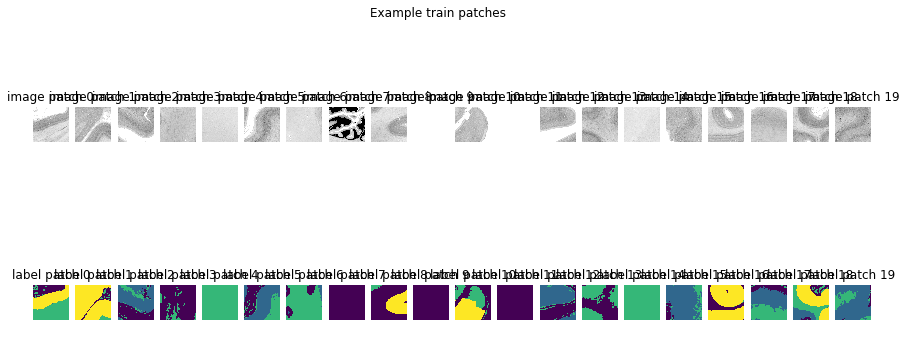

In [163]:
# load precomputed train patches
res = np.load(os.path.join(data_dir, "train_v1gmwm.npz"))
X_train = res['X']
Y_train = res['Y']
res.close()

# load precomputed val patches
res = np.load(os.path.join(data_dir, "val_v1gmwm.npz"))
X_val = res['X']
Y_val = res['Y']
res.close()

# visualize image and label patches
fig = plot_dataset(X_val, Y_val, num=20, vmax_labels=3)
fig.suptitle("Example val patches")

# 2.2. Train model

In [147]:
# create network architecture
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor, num_classes=4)

# crop groundtruth labels to fit to the smaller output size of the model (due to only 'valid' convolutions)
Y_train_cropped = crop_to_shape(Y_train, model.output.shape.as_list()[1:3])
Y_val_cropped = crop_to_shape(Y_val, model.output.shape.as_list()[1:3])
print("Shape before cropping: {}. Shape after cropping: {}.".format(Y_train.shape, Y_train_cropped.shape))

# create generator for batches that centers mean and std deviation of training data
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(X_train)

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


Shape before cropping: (500, 268, 268, 1). Shape after cropping: (500, 84, 84, 1).


In [154]:
model.load_weights('model_gmwm.hdf5', by_name=True, skip_mismatch=True )

In [168]:
# parameters for training
lr = 0.005
momentum = 0.9
epochs = 50
batch_size = 24
model_name = 'model_v1_long.hdf5' # first 50 epochs 0.01, then 50 epochs 0.005
# TODO use learning rate reduction schedule - show performance of model in between - not as good!

# prepare model for training
sgd = SGD(lr=lr, momentum=momentum, nesterov=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=[sparse_categorical_accuracy] )

# train model
history_v1 = model.fit_generator(datagen.flow(X_train, Y_train_cropped, batch_size=batch_size),
                             steps_per_epoch=X_train.shape[0]//batch_size, 
                              epochs=epochs, verbose=2,
                             validation_data=datagen.flow(X_val, Y_val_cropped, batch_size=len(X_val)).next())

# save model   
model.save(model_name)



Epoch 1/50
 - 14s - loss: 0.2617 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.7145 - val_sparse_categorical_accuracy: 0.7854
Epoch 2/50
 - 11s - loss: 0.2406 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.7799
Epoch 3/50
 - 11s - loss: 0.2262 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.8251 - val_sparse_categorical_accuracy: 0.7899
Epoch 4/50
 - 11s - loss: 0.2145 - sparse_categorical_accuracy: 0.9168 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.7753
Epoch 5/50
 - 11s - loss: 0.2078 - sparse_categorical_accuracy: 0.9186 - val_loss: 0.8873 - val_sparse_categorical_accuracy: 0.7912
Epoch 6/50
 - 11s - loss: 0.1715 - sparse_categorical_accuracy: 0.9336 - val_loss: 0.8963 - val_sparse_categorical_accuracy: 0.7773
Epoch 7/50
 - 11s - loss: 0.2656 - sparse_categorical_accuracy: 0.9011 - val_loss: 0.5660 - val_sparse_categorical_accuracy: 0.8068
Epoch 8/50
 - 11s - loss: 0.2026 - sparse_categorical_accuracy: 0.9224 - val

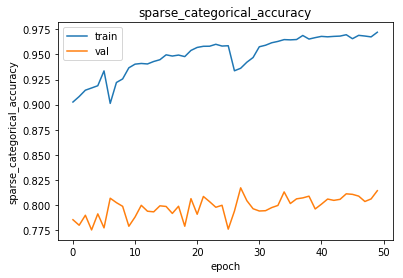

In [170]:
plot_history(history_v1, key='sparse_categorical_accuracy')

# 2.3. Evaluate model

In [171]:
# recreate unet model with larger input size
input_shape = (1020,1020,1)
model_name = 'model_v1_long.hdf5'

input_tensor = Input(shape=input_shape)
eval_model = u_net(input_tensor, num_classes=4)
eval_model.load_weights(model_name)


/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


In [172]:
# predict large image by predicting grid of small overlapping images

# load image to predict
X_test = imageio.imread(sections_fname.format(test_sections[4]))
Y_test = imageio.imread(masks_v1_fname.format(test_sections[4]))

# create slightly overlapping patches from whole slide section
grid = create_grid(X_test, spacing=eval_model.output_shape[1])
patches = sample_from_coords(X_test, grid, patch_shape=eval_model.input_shape[1:3])

# predict patches
patches_to_predict = np.expand_dims(patches,3)
predicted_patches = eval_model.predict_generator(datagen.flow(patches_to_predict, batch_size=1, shuffle=False), steps=len(patches_to_predict))

# create predicted image from patches
Z_test = create_image_from_patches(predicted_patches, grid, X_test.shape)

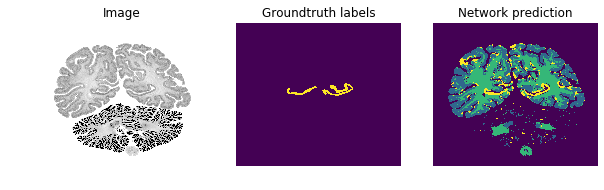

In [173]:
# show results
fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].imshow(X_test, cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(Y_test)
axes[1].set_title("Groundtruth labels")
axes[2].imshow(Z_test)
axes[2].set_title("Network prediction")
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')

# OTHER STUFF - Under development

## 1.4. Include data augmentation

- use random rotations and mirrorings of the input patches


In [101]:
# create generator for batches that centers mean and std deviation of training data and that uses data augmentation
datagen_aug = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True, vertical_flip=True)
datagen_aug.fit(X_train)
# another generator for the labels which should also be flipped accordingly
datagen_aug_labels = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)


Text(0.5, 0.98, 'Without augmentation')

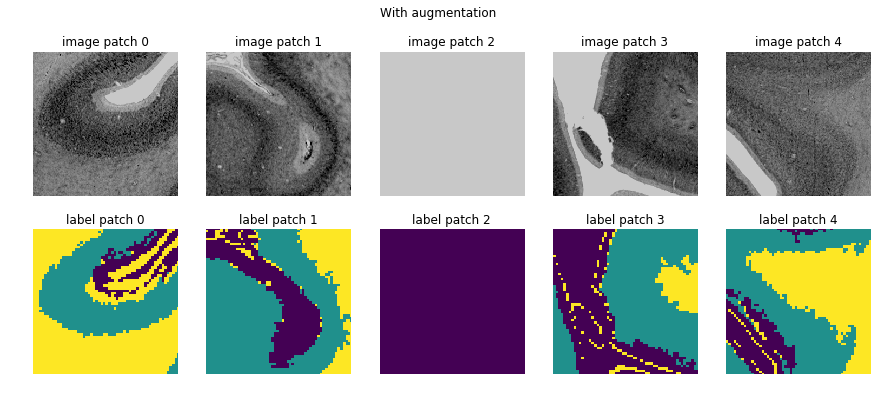

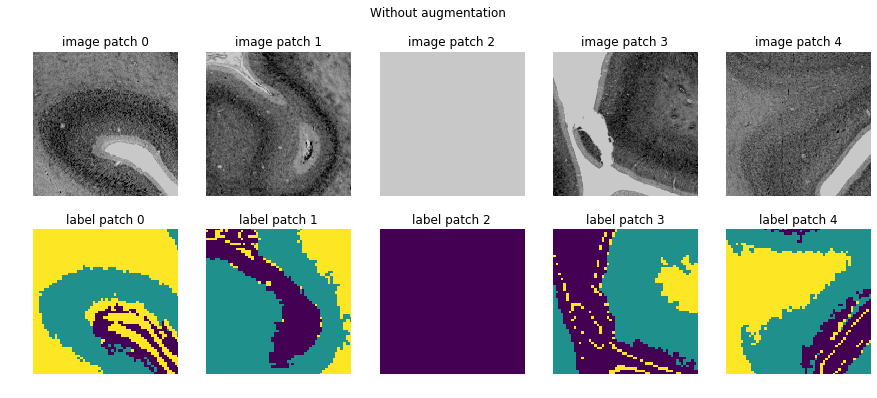

In [102]:
seed = 100
# visualize augmented patches
xs = datagen_aug.flow(X_train, batch_size=5, seed=seed).next()
ys = datagen_aug_labels.flow(Y_train, batch_size=5, seed=seed).next()

fig = plot_dataset(xs, ys, vmin=-2, vmax=2)
fig.suptitle('With augmentation')
    
# visualize original patches for comparison
xs, ys = datagen.flow(X_train, Y_train, batch_size=5, seed=seed).next()

fig = plot_dataset(xs, ys, vmin=-2, vmax=2)
fig.suptitle('Without augmentation')

In [105]:
# train model with data augmentation
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor)

# parameters for training
lr = 0.001
momentum = 0.9
epochs = 10
batch_size = 24
model_name = 'model_gmwm_aug.hdf5'

# prepare model for training
sgd = SGD(lr=lr, momentum=momentum, nesterov=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=[sparse_categorical_accuracy] )

# train model
# combine patch and label datagenerator
traingen = zip(datagen_aug.flow(X_train, batch_size=batch_size, seed=42), 
               datagen_aug_labels.flow(Y_train_cropped, batch_size=batch_size, seed=42))
history_gmwm_aug = model.fit_generator(traingen,
                             steps_per_epoch=X_train.shape[0]//batch_size, 
                             epochs=epochs, verbose=2,
                             # for validation, use non-augmented data
                             validation_data=datagen.flow(X_val, Y_val_cropped, batch_size=len(X_val)).next()
                                      )

# save model   
model.save(model_name)



/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


Epoch 1/10
 - 12s - loss: 1.0832 - sparse_categorical_accuracy: 0.3746 - val_loss: 1.0686 - val_sparse_categorical_accuracy: 0.4304
Epoch 2/10
 - 11s - loss: 1.0437 - sparse_categorical_accuracy: 0.5702 - val_loss: 1.0200 - val_sparse_categorical_accuracy: 0.7070
Epoch 3/10
 - 11s - loss: 0.9744 - sparse_categorical_accuracy: 0.6555 - val_loss: 0.9397 - val_sparse_categorical_accuracy: 0.7147
Epoch 4/10
 - 11s - loss: 0.8697 - sparse_categorical_accuracy: 0.6546 - val_loss: 0.8235 - val_sparse_categorical_accuracy: 0.7100
Epoch 5/10
 - 11s - loss: 0.7595 - sparse_categorical_accuracy: 0.6520 - val_loss: 0.7347 - val_sparse_categorical_accuracy: 0.7111
Epoch 6/10
 - 11s - loss: 0.7416 - sparse_categorical_accuracy: 0.6544 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.7200
Epoch 7/10
 - 11s - loss: 0.6943 - sparse_categorical_accuracy: 0.6957 - val_loss: 0.6676 - val_sparse_categorical_accuracy: 0.7326
Epoch 8/10
 - 11s - loss: 0.6859 - sparse_categorical_accuracy: 0.7152 - val

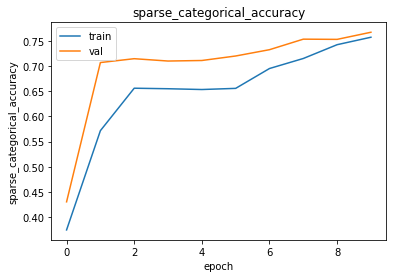

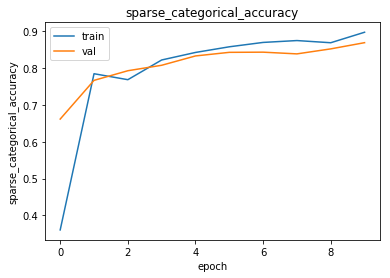

In [106]:
# compare with non-augmented model
plot_history(history_gmwm_aug, key='sparse_categorical_accuracy')
plot_history(history_gmwm, key='sparse_categorical_accuracy')

# What did the model learn? 
- Several techniques for looking inside the network. 
- Easiest: looking at learned first layer weights


In [13]:
model.load_weights(model_name)

In [106]:
import vis

In [ ]:
# use keras-vis for saliency: https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb

In [112]:
visualize_saliency?

In [114]:
patches_to_predict.shape

(56, 1020, 1020, 1)

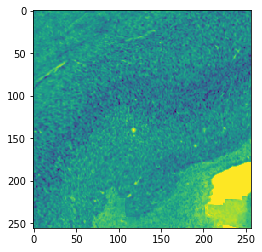

In [119]:
plt.imshow(X_val[15,:,:,0])

In [17]:
rf = calculate_receptive_field(model)
print(rf)

184.0


In [18]:
crop_to_shape?

In [24]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = -1

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model_saliency = utils.apply_modifications(model)

grads = visualize_saliency(model_saliency, layer_idx, filter_indices=1, seed_input=X_val[15], backprop_modifier='guided')
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [22]:
%matplotlib notebook

<IPython.core.display.Javascript object>


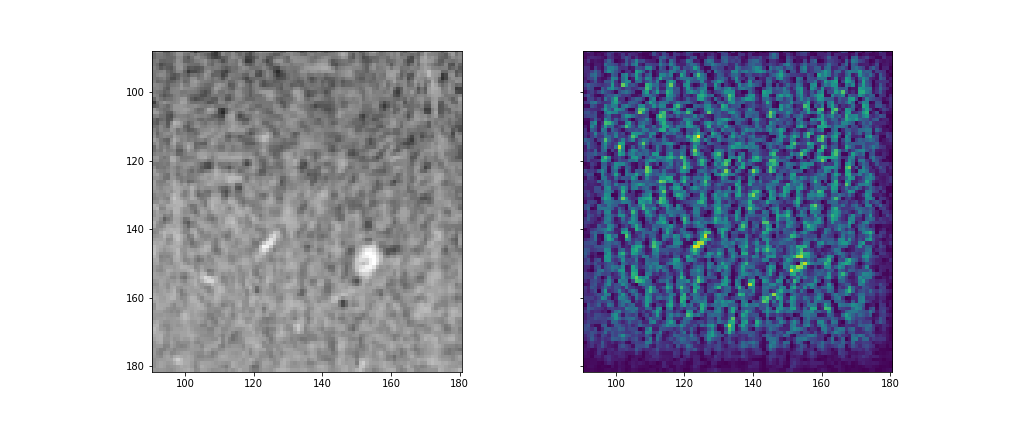

In [29]:
grads = visualize_saliency(model_saliency, layer_idx, filter_indices=0, seed_input=X_val[15], backprop_modifier='guided')

fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].imshow(X_val[15,:,:,0], cmap='gray')
axes[1].imshow(grads)

<IPython.core.display.Javascript object>


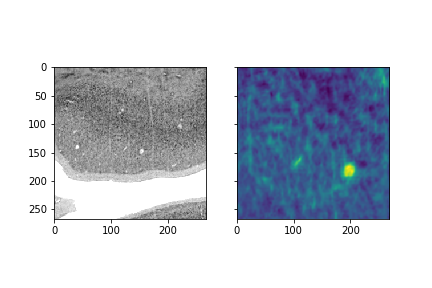

In [32]:
from vis.visualization import visualize_cam

grads = visualize_cam(model_saliency, layer_idx, filter_indices=2, seed_input=X_val[15], backprop_modifier='guided')

fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].imshow(X_val[15,:,:,0], cmap='gray')
axes[1].imshow(grads)
